<font size="6">**Neural network architecture**</font>
<br><br>


<table>
    <tr>
        <th>Variable</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>OUTPUTS</td>
        <td><i>array containing all possible outputs</i></td>
    </tr>
    <tr>
        <td>NB_HIDDEN_LAYERS</td>
        <td><i>integer</i></td>
    </tr>
    <tr>
        <td>NB_HIDDEN_NODES</td>
        <td><i>array containing the number of hidden nodes for each hidden layer (from the first one to the last one)</i></td>
    </tr>
    <tr>
        <td>NB_INPUTS </td>
        <td><i>number of nodes on the input layer</i></td>
    </tr>
    <tr>
        <td>NB_EPOCH </td>
        <td><i>number of times the training data set will be used entirely to train the network</i></td>
    </tr>
</table>


In [60]:
#OUTPUTS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
OUTPUTS = [2, 3, 8, 9]
NB_OUTPUTS = len(OUTPUTS)
NB_HIDDEN_LAYERS = 1
NB_HIDDEN_NODES = [124]
NB_INPUTS = 784
NB_EPOCH = 10
network = list()

<font size="6">**Neural Network Training settings**</font>
<br><br>


<table>
    <tr>
        <th style="text-align: center">Variable</th>
        <th style="text-align: center">Description</th>
    </tr>
    <tr>
        <td colspan="2" style="text-align: center"><font size="4">Training dataset</font></td>
    </tr>
    <tr>
        <td>NB_DATA</td>
        <td style="text-align: left"><i>integer - Number of data used in the dataset</i></td>
    </tr>
    <tr>
        <td>TRAINING PATH</td>
        <td style="text-align: left"><i>string - relative or full path of the training dataset folder</i></td>
    </tr>
    <tr>
        <td>DATA_TYPE</td>
        <td style="text-align: left"><i>string - either 'img' or 'xor', depends on type of input data</i></td>
    </tr>
    <tr>
        <td colspan="2" style="text-align: center"><font size="4">Learning rate</font></td>
    </tr>
    <tr>
        <td>L_RATE</td>
        <td style="text-align: left"><i>float - Initial learning rate for the first epoch</i></td>
    </tr>
    <tr>
        <td>L_RATE_DESC</td>
        <td style="text-align: left"><i>float - variation of the learning rate : L_RATE * L_RATE_DESC at the end of each epoch. If no variation then L_RATE_DESC = 1.0</i></td>
    </tr>
    <tr>
        <td colspan="2" style="text-align: center"><font size="4">Weights</font></td>
    </tr>
    <tr>
        <td style="text-align: center">WEIGHTS_LOW_BOUND</td>
        <td style="text-align: left"><i>float or integer - Weights are initialized randomly in a range of values</i></td>
    </tr>
    <tr>
        <td>WEIGHTS_HIGH_BOUND</td>
        <td style="text-align: left"><i>float or integer - Weights are initialized randomly in a range of values</i></td>
    </tr>
    <tr>
        <td colspan="2" style="text-align: center"><font size="4">Error</font></td>
    </tr>
    <tr>
        <td>ERR_THRESHOLD</td>
        <td style="text-align: left"><i>Minimum limit for the error value. If reached, the network can stop learning. Accuracy is good enough</i></td>
    </tr>
    <tr>
        <td colspan="2" style="text-align: center"><font size="4">Train with additional data</font></td>
    </tr>
    <tr>
        <td>RETRAIN</td>
        <td style="text-align: left"><i>If set to 0, the network is initialized with random weights and values. If set to 1, it starts the training with the training result of the last execution.</i></td>
    </tr>
</table>


In [61]:
# TRAINING DATASET
NB_DATA = 40000
TRAINING_PATH = '../training/'
DATA_TYPE = 'img'

# LEARNING RATE
L_RATE = 0.01
L_RATE_DESC = 1.0

# INITIAL WEIGHTS RANGE
WEIGHTS_LOW_BOUND = -0.5
WEIGHTS_HIGH_BOUND = 0.5

# ERROR THRESHOLD
ERR_THRESHOLD = 0.001

# RETRAIN
RETRAIN = 0

<font size="6">**Load dataset**</font>
<br><br>


In [62]:
from PIL import Image
import random
import numpy as np
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def loadImage(img_path, number = 0):
    pix = np.asarray(Image.open(img_path).convert('L'))
    pix = ((pix * (1 / 2550) - 0.05)).reshape(784)
    expected = []
    if OUTPUTS != []:
        for i in OUTPUTS:
            if i == number:
                expected = np.append(expected, 1)
            else:
                expected = np.append(expected, 0)
    return pix, expected

def printImage(img_path):
    plt.close()
    plt.figure()
    img = Image.open(img_path)
    img = img.resize((12, 12), Image.ANTIALIAS)
    print(img)
    plt.pause(1)
    
def load_training_dataset():
    dataset = []
    expected = []
    
    filenames = []
    for o in OUTPUTS:
        for filename in glob.glob(TRAINING_PATH + str(o) + '/*.png'): 
            base = os.path.basename(filename)
            filenames.append([str(o) + '/' + base, o])
    
    random.shuffle(filenames)
    if NB_DATA != 0:
        filenames = filenames[:NB_DATA]
        
    for file in filenames:
        img, exp = loadImage(TRAINING_PATH + file[0], file[1])
        dataset.append(img)
        expected.append(exp)
        
    return dataset, expected

<font size="6">**Neural network - Initialization**</font>
<br><br>

In [63]:
def initialize_network():
    
    global network
    w = []
    
    # additionnal hidden layers
    for i in range(NB_HIDDEN_LAYERS):
        neurons = [{ 'neurons': NB_HIDDEN_NODES[i]}]
        if i == 0:
            w.append(np.random.uniform(low=WEIGHTS_LOW_BOUND, high=WEIGHTS_HIGH_BOUND, size=(NB_HIDDEN_NODES[i], NB_INPUTS)))
        else:
            w.append(np.random.uniform(low=WEIGHTS_LOW_BOUND, high=WEIGHTS_HIGH_BOUND, size=(NB_HIDDEN_NODES[i], NB_HIDDEN_NODES[i - 1])))

        network.append(neurons)
    
    # output layer
    neurons = [{ 'neurons': NB_OUTPUTS}]
    w.append(np.random.uniform(low=WEIGHTS_LOW_BOUND, high=WEIGHTS_HIGH_BOUND, size=(NB_OUTPUTS, NB_HIDDEN_NODES[NB_HIDDEN_LAYERS - 1])))
    network.append(neurons)
    
    for layer in network:
              
        wTmp = {'w': w[0]}
        layer.append(wTmp)
        w.pop(0)
        
        aTmp = { 'a': np.matrix(np.random.rand(layer[0]['neurons']))}
        layer.append(aTmp)
        
        eTmp = { 'e': np.matrix(np.random.rand(layer[0]['neurons']))}
        layer.append(eTmp)
        
    return network
  

<font size="6">**Deep Learning - Forward Propagation**</font>
<br><br>


In [64]:
import numpy as np
import math
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
 
def forward_prop(inputs):
    global network
    vect_sigmoid = np.vectorize(sigmoid)
    
    for i in range(len(network)):
        layer = network[i]
        new_inputs = []
        
        if (inputs.shape)[0] == 1 :
            layer[0]['a'] = vect_sigmoid(np.dot(layer[1]['w'], inputs.T))
        else:
            layer[0]['a'] = vect_sigmoid(np.dot(layer[1]['w'], inputs))

        new_inputs.append(layer[0]['a'])
        inputs = new_inputs[0]
    return np.matrix(inputs)

<font size="6">**Deep Learning - Backpropagation error**</font>
<br><br>


In [65]:
# Update network weights with error
def update_weights(data):
    delta = []
    global L_RATE
    
    for i in range(len(network)):
        layer = network[i]
        
        if i != 0:
            delta = np.multiply((layer[3]['e'] * L_RATE).T, network[i - 1][0]['a'])
        else:
            delta = np.multiply((layer[3]['e'] * L_RATE).T, data)
        layer[1]['w'] = layer[1]['w'] + delta.T
        
def backward_prop_error(expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        
        # case where it is not the output layer
        if i != len(network)-1:
            o_errors = network[i + 1][3]['e']
            o_weights = network[i + 1][1]['w']
            
            errors = np.dot(
                np.dot(o_weights.T, o_errors),
                np.dot((layer[0]['a'].T), 1 - layer[0]['a']))
            
            layer[3]['e'] = errors
        else:
            errors = np.dot(expected.T - layer[0]['a'], np.dot((layer[0]['a']).T, (1 - layer[0]['a'])))
            layer[3]['e']  = errors
            

    

<font size="6">**Neural network - Training**</font>
<br><br>

* **train_network()**
<br>
Executes the whole training process (forward propagation + backward propagation error + updating weights) for each epoch
<br><br>

* **error_function**(expected outputs: array of integers, outputs of the program: array of floats)
<br>
Calculates the average error for each output when processing element thru the neural network
<br>
It is based on MSE (Mean Squared Error)
<br><br>

* **update_line**(plot: plt, new error value: integer, iter: integer)
<br>
Adds the newly calculated error to the graph showing evolution of the error function values

In [66]:
import time

def error_function(expected, outputs):
    return (1/len(OUTPUTS)) * sum(np.square(expected - outputs))
    #return sum(np.square(expected - outputs))

def update_line(hl, new_data, iter):
    hl.set_xdata(np.append(hl.get_xdata(), iter))
    hl.set_ydata(np.append(hl.get_ydata(), new_data))
    plt.draw()


def train_network():

    start = time.time()
    global network
    global L_RATE
    global L_RATE_DESC
    expected = []
    dataset = []
    
    
    # ------ Initialization part -------
    
    if DATA_TYPE == 'img':
        if dataset == []:
            dataset, exp = load_training_dataset()
            x = np.matrix(dataset)
            expected = np.matrix(exp)
        else:
            x = dataset
    elif DATE_TYPE == 'xor':
        x = np.matrix([[1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 1]])
    else:
        return 'Wrong datatype (should be iprintpmg or xor)'

    if RETRAIN == 0:
        network = initialize_network()
    
    
    # --------- Training part ----------
    
    err_plot, = plt.plot([], [])
    plt.ylabel('error')
    axes = plt.gca()
    iter = 0
    
    for epoch in range(NB_EPOCH):
        error = 0
        iter = 0
        for data in x:
            new_data = data.T
            
            # ---------- Forward propagation ---------------
            outputs = forward_prop(new_data)
            
            # ---------- Calculating error (MSE) -----------
            error += error_function(expected[iter].T, outputs)
            
            # ---------- Backward propagation error --------
            backward_prop_error(expected[iter])
            
            # ---------- Updating weights ------------------
            update_weights(new_data)
            
            iter += 1
            
        # ---------- Calculating and displaying error after one epoch ------------------
        final_err = error / len(x)
        print('>>> iter/epoch = %d, learning rate = %.3f, error = %.5f' % (epoch + 1, L_RATE, final_err))
        
        # ---------- Initializing graph for first epoch (based on first error value) ---
        if epoch == 0:
            axes.set_xlim([0, NB_EPOCH - 1])
            axes.set_ylim([0, float(final_err) + 0.01])
            
        # ---------- Updating error graph --------
        update_line(err_plot, final_err, epoch)
        
        if error < ERR_THRESHOLD:
            print('error : ' + str(final_err))
            return network
        
        L_RATE *= L_RATE_DESC
        
        
        dataset, exp = load_training_dataset()
        x = np.matrix(dataset)
        expected = np.matrix(exp)
        
    print('error     : ' + str(final_err))
    
    end = time.time()
    print('\nFunction Training executed in ' + str(end - start) + 's')
    return network


<font size="6">**Execution - Training**</font>
<br><br>

>>> iter/epoch = 1, learning rate = 0.010, error = 0.04457
>>> iter/epoch = 2, learning rate = 0.010, error = 0.03198
>>> iter/epoch = 3, learning rate = 0.010, error = 0.02941
>>> iter/epoch = 4, learning rate = 0.010, error = 0.02811
>>> iter/epoch = 5, learning rate = 0.010, error = 0.02717
>>> iter/epoch = 6, learning rate = 0.010, error = 0.02655
>>> iter/epoch = 7, learning rate = 0.010, error = 0.02592
>>> iter/epoch = 8, learning rate = 0.010, error = 0.02546
>>> iter/epoch = 9, learning rate = 0.010, error = 0.02505
>>> iter/epoch = 10, learning rate = 0.010, error = 0.02468
error     : [[0.02467733]]

Function Training executed in 252.23997235298157s


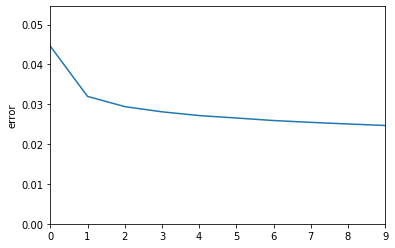

In [67]:
network = train_network()

<font size="6">**Predict - Settings**</font>
<br><br>

In [48]:
#PREDICT_PATH = 'D:\Testing data'
PREDICT_PATH = 'D:\\testing'
OUTPUT_FILE = '710883299 - outputs.txt'
NB_PREDICT_DATA = 800

<font size="6">**Predict**</font>
<br><br>
* Generates a .txt file as an output 

[NAME OF THE FILE] Program output

ex:

0001 5
<br>
0002 9

In [49]:
import time

def predict():
    start = time.time()
    predict_o = []
    filenames = []
    wrong = []
    correct = 0
    
    for filename in glob.glob(PREDICT_PATH + '/*.png'):
        base = os.path.splitext(os.path.basename(filename))[0]
        data = loadImage(filename)
        filenames.append(base)

        output = forward_prop(data[0])

        val = [i for i in np.where(output == np.amax(output))]
        predict_o.append(np.around(OUTPUTS[val[0][0]]).astype(int))
            
    final = list()

    for i in range(len(filenames)):
        final.append({ filenames[i] : predict_o[i]})

    with open(OUTPUT_FILE, 'w') as f:
        for item in final:
            f.write("%s\n" % str(item).replace('{', '').replace('}', '').replace("'", '').replace(':', ''))

    print('Completed - Output file generated')
    
    end = time.time()
    print('\nPrediction executed in ' + str(end - start) + 's')

<font size="6">**Execution - Predict**</font>
<br><br>

In [50]:
predict()

Completed - Output file generated

Prediction executed in 28.231493711471558s


<font size="6">**Accuracy tests - Settings**</font>
<br><br>

In [26]:
TESTING_PATH = '../training/'
DISP_ERRORS_LIMIT = 7

<font size="6">**Accuracy tests**</font>
<br><br>

* Takes a dataset and compares program output with real values

In [27]:
def accuracy_check():
    predict_o = []
    filenames = []
    wrong = []
    correct = 0
    for number in OUTPUTS:
        for filename in glob.glob(TESTING_PATH + str(number) + '/*.png'):
            base = os.path.splitext(os.path.basename(filename))[0]
            data = loadImage(filename)
            filenames.append(base)
            
            output = forward_prop(data[0])

            val = [i for i in np.where(output == np.amax(output))]
            ans = np.around(OUTPUTS[val[0][0]]).astype(int)

            if ans == number:
                correct += 1
            else:
                wrong.append([number, ans, filename])
            predict_o.append(ans)
            
    final = list()

    for i in range(len(filenames)):
        final.append({ filenames[i] : predict_o[i]})


    with open('outputs.txt', 'w') as f:
        for item in final:
            f.write("%s\n" % str(item).replace('{', '').replace('}', '').replace("'", '').replace(':', ''))
            
    print('correct : %d ( %.2f %s)' % (correct, (correct / len(filenames)) * 100, '%'))
    print('wrong   : %d ( %.2f %s)' % (len(filenames) - correct, ((len(filenames) - correct) / len(filenames)) * 100, '%'))
    

def predict_one(data = []):
    files = []
    if data == []:
        for number in OUTPUTS:
            for filename in glob.glob(TESTING_PATH + str(number) + '/*.png'):
                f = TESTING_PATH + str(number) + '/' + os.path.basename(filename)
                files.append([number, f])
        
        input = random.choice(files)
        filename = input[1]
        correct = input[0]
    else:
        filename = data[2]
        ans = data[1]
        correct = data[0]
    img, exp = loadImage(filename)

    output = forward_prop(np.matrix(img))
    
    if data == []:
        val = [i for i in np.where(output == np.amax(output))]
        ans = np.around(OUTPUTS[val[0][0]]).astype(int)
    
    printImage(filename)
    print('program output : ' + str(ans))
    print('correct output : ' + str(correct))

<font size="5">**Accuracy test - Percentage of correct/wrong answers**</font>
<br><br>

In [68]:
accuracy_check()

correct : 15172 ( 94.83 %)
wrong   : 828 ( 5.17 %)


<font size="5">**Accuracy test - Comparing results in details**</font>
<br><br>
* Displaying the test image
* Displaying the output of the program (different from the expected output)
* Displaying the expected answer

**/!\ It is better to try it with 5 to 8 errors (for display and performance reasons)**

In [126]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import time

def displayResults():
    wrong = predict()
    iter = 0
    for w in wrong:
        if iter > 10:
            break
        predict_one(w)
        iter += 1
        
def display_errors():
    start = time.time()
    
    filenames = []
    correct = []
    ans = []
    files = []
    numbers = []
    
    # choose the random numbers
    for i in range(DISP_ERRORS_LIMIT):
        numbers.append(random.choice(OUTPUTS))
        
    # get all the file names we will use
    for n in numbers:
        ok = 0
        while ok == 0:
            tmp_path = TESTING_PATH + str(n) + '/' + random.choice(os.listdir(TESTING_PATH + str(n)))
            
            img, exp = loadImage(tmp_path)
            output = forward_prop(np.matrix(img))
            
            val = [i for i in np.where(output == np.amax(output))]
            ans_tmp = np.around(OUTPUTS[val[0][0]]).astype(int)
            
            if ans_tmp != n:
                correct.append(n)
                ans.append(ans_tmp)
                filenames.append(tmp_path)
                ok = 1
        
    showImages(filenames, correct, ans)
    
    end = time.time()
    print('Function executed in ' + str(end - start) + 's')


def showImages(filenames, correct, ans):
    fig = figure(figsize= (20,20))
    nb_files = len(filenames)
    for i in range(nb_files):
        a = fig.add_subplot(1, nb_files, i+1)
        image = imread(filenames[i])
        a.title.set_text('number : %d | output : %d' % (correct[i], ans[i]))
        imshow(image, cmap='Greys_r')
        axis('off')

Function executed in 0.5365993976593018s


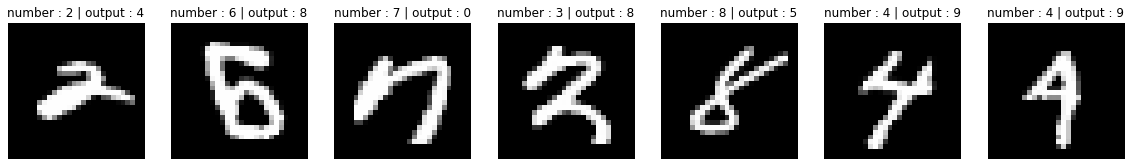

In [134]:
display_errors()